In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model


# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [7]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:,0:-1]


2021-12-23 21:25:03.916003: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-12-23 21:25:03.975210: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 21:25:03.975589: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-12-23 21:25:03.975609: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-12-23 21:25:03.976470: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-12-23 21:25:03.977339: I tensorflow/stream_executor/platfo

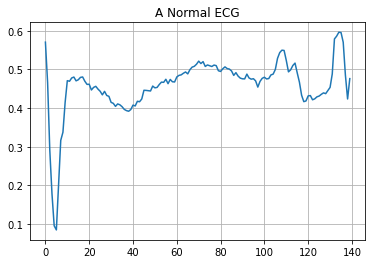

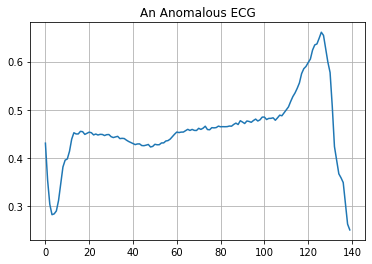

In [8]:
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

# Normalize the data to [0,1]
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val-min_val)
test_data = (test_data - min_val) / (max_val-min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)


train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

# print(test_labels.shape)
# print(test_data)
# print(normal_test_data)

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

# Plot a normal ECG
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

# Plot an anomalous ECG
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

In [9]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(32, activation='relu'),
            layers.Dense(16, activation='relu'),
            layers.Dense(8, activation='relu')])
        
        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(140, activation='sigmoid')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder = AnomalyDetector() 

In [10]:
autoencoder.compile(optimizer='adam', loss='mae')

history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=20,
          batch_size=512,
          shuffle=True,
          validation_data=(normal_test_data, normal_test_data))

autoencoder.encoder.summary()
autoencoder.decoder.summary()

Epoch 1/20
5/5 [==============================] - 0s 18ms/step - loss: 0.0576 - val_loss: 0.0561
Epoch 2/20
5/5 [==============================] - 0s 3ms/step - loss: 0.0549 - val_loss: 0.0525
Epoch 3/20
5/5 [==============================] - 0s 3ms/step - loss: 0.0510 - val_loss: 0.0482
Epoch 4/20
5/5 [==============================] - 0s 3ms/step - loss: 0.0466 - val_loss: 0.0437
Epoch 5/20
5/5 [==============================] - 0s 3ms/step - loss: 0.0423 - val_loss: 0.0396
Epoch 6/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0384 - val_loss: 0.0361
Epoch 7/20
5/5 [==============================] - 0s 3ms/step - loss: 0.0351 - val_loss: 0.0332
Epoch 8/20
5/5 [==============================] - 0s 3ms/step - loss: 0.0326 - val_loss: 0.0310
Epoch 9/20
5/5 [==============================] - 0s 3ms/step - loss: 0.0305 - val_loss: 0.0291
Epoch 10/20
5/5 [==============================] - 0s 3ms/step - loss: 0.0288 - val_loss: 0.0276
Epoch 11/20
5/5 [=====================

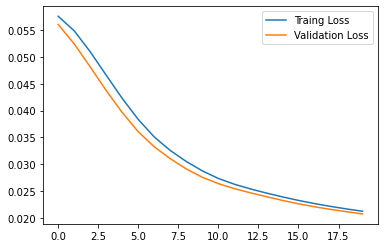

In [11]:
plt.plot(history.history["loss"], label="Traing Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()


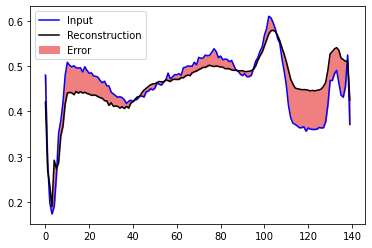

In [12]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0],'b')
plt.plot(decoded_data[0],'k')
plt.fill_between(np.arange(140),decoded_data[0],normal_test_data[0],color='lightcoral')
plt.legend(["Input", "Reconstruction","Error"])

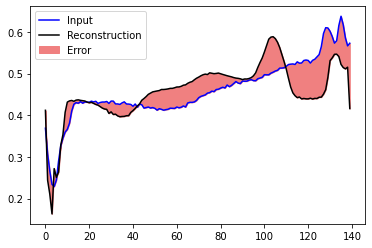

In [13]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0],'b')
plt.plot(decoded_data[0],'k')
plt.fill_between(np.arange(140),decoded_data[0],anomalous_test_data[0],color='lightcoral')
plt.legend(labels=["Input", "Reconstruction","Error"])

(2359, 140)
(2359,)


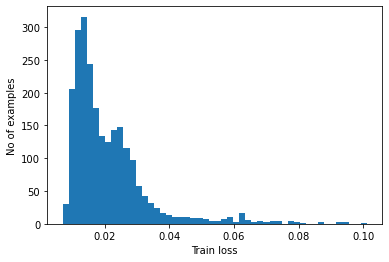

In [14]:
# Detect anomalies
reconstructions = autoencoder.predict(normal_train_data)
print(reconstructions.shape)
train_loss = losses.mae(reconstructions, normal_train_data)
print(train_loss.shape)
plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [15]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold:",threshold)

Threshold: 0.033082943


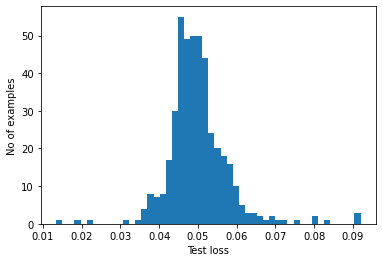

In [18]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [25]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print(f"Accuracy = {accuracy_score(labels, predictions)}")
  print(f"Precision = {precision_score(labels, predictions)}")
  print(f"Recall = {recall_score(labels, predictions)}")

preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.945
Precision = 0.9922027290448343
Recall = 0.9089285714285714
